## Importing Libraries

In [1]:
%matplotlib inline
! pip install pkbar==0.4
import math
from typing import Union, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, OneCycleLR
from pkbar import Kbar
from tqdm import tqdm

## Config

In [2]:
# defining variables
seed = 1
batch_size = 128
batch_size_2 = 64
num_workers = 4
epochs = 25

In [3]:
# configuring
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed(seed)
print("device: %s" % device)

device: cuda


## Dataset stuff

### Defining Transforms

In [4]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(fill=(0,),degrees=(-5,5)), # Randomly rotating the image in the range -5,5 degrees
    transforms.ToTensor(), # Converting to Tensor
    transforms.Normalize((0.1307,), (0.3081,)) # Normalizing the dataset with the mean and std 
])

# Test transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(), # Converting to Tensor
    transforms.Normalize((0.1307,),(0.3081,))  # Normalizing the dataset using mean and std
])

### Downloading dataset

In [5]:
train_dataset = datasets.MNIST(
    "./data", 
    train=True,
    download=True,
    transform=train_transforms
)
test_dataset = datasets.MNIST(
    "./data", 
    train=False,
    download=True,
    transform=test_transforms
)

### Creating DataLoader

In [6]:
dataloader_args = dict(
    shuffle = True,
    batch_size = batch_size,
    num_workers = num_workers,
    pin_memory = True
) if device == "cuda" else dict(
    shuffle = True,
    batch_size = batch_size_2
)

train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

## The Model

In [7]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [8]:
class Net(nn.Module):
    def __init__(self, use_ghost_batch_norm = False):
        super(Net,self).__init__()
        dropout_value = 0
        num_splits = 2
        # Convolution Block 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=7, kernel_size=(3, 3),padding=0, bias=False),
            nn.BatchNorm2d(7) if not use_ghost_batch_norm else GhostBatchNorm(7, num_splits),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        # Convolution Block 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=7, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16) if not use_ghost_batch_norm else GhostBatchNorm(16, num_splits),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        # Transition Block 1
        self.transitionblock1 = nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            nn.MaxPool2d(2,2)
        )

        # Convolution Block 3
        self.convblock3= nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16) if not use_ghost_batch_norm else GhostBatchNorm(16, num_splits),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        # Convolution Block 4
        self.convblock4= nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16) if not use_ghost_batch_norm else GhostBatchNorm(16, num_splits),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.convblock5= nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16) if not use_ghost_batch_norm else GhostBatchNorm(16, num_splits),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5),
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=True)
        )
  
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.transitionblock1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.gap(x)
        x = x.view(-1,10)
        return F.log_softmax(x,dim = -1)

### Model Summary

In [9]:
summary(Net().to(device), input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 7, 26, 26]              63
       BatchNorm2d-2            [-1, 7, 26, 26]              14
              ReLU-3            [-1, 7, 26, 26]               0
           Dropout-4            [-1, 7, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,008
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 12, 24, 24]             192
        MaxPool2d-10           [-1, 12, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,728
      BatchNorm2d-12           [-1, 16, 10, 10]              32
             ReLU-13           [-1, 16, 10, 10]               0
          Dropout-14           [-1, 16,

In [10]:
class History:
    def __init__(self, train_losses, train_accs, test_losses, test_accs):
        self.test_losses = test_losses
        self.test_accs = test_accs
        self.train_losses = train_losses
        self.train_accs = train_accs

class Solver:
    def __init__(self, model):
        self.model = model
        self.test_losses = []
        self.test_accs = []
        self.train_losses = []
        self.train_accs = []

    def train(self, epochs, train_loader, test_loader, optimizer, scheduler = None, device = "cpu", loss_fn = None, use_tqdm = False):
        if loss_fn is None:
            loss_fn = F.nll_loss

        for epoch in range(epochs):
            print("Epoch: %d / %d" % (epoch + 1, epochs))
            self._train_step(train_loader, optimizer, scheduler, device, loss_fn, use_tqdm)

            if scheduler is not None and not isinstance(scheduler, OneCycleLR):
                scheduler.step()

            self._test_step(test_loader, device)

        return History(self.train_losses, self.train_accs, self.test_losses, self.test_accs)

    def _train_step(self, train_loader, optimizer, scheduler, device, loss_fn, use_tqdm):
        # setting model in train mode
        self.model.train()

        # creating progress bar
        if use_tqdm:
            pbar = tqdm(train_loader)
            iterator = pbar
        else:
            pbar = Kbar(len(train_loader), stateful_metrics=["loss", "accuracy"])
            iterator = train_loader

        # defining variables
        correct = 0
        processed = 0
        train_loss = 0
        for batch_idx, (data, target) in enumerate(iterator):
            # casting to device
            data, target = data.to(device), target.to(device)

            # zeroing out accumulated gradients
            optimizer.zero_grad()

            # forward prop
            y_pred = self.model(data)

            # calculating loss
            loss = loss_fn(y_pred, target)
            train_loss += loss.detach()

            # backpropagation
            loss.backward()
            optimizer.step()

            # calculating accuracy
            pred = y_pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)

            # updating progress bar
            if use_tqdm:
                pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100 * correct / processed:0.2f}')
            else:
                pbar.update(
                    batch_idx, values=[("loss", loss.item()), ("accuracy", 100 * correct / processed)]
                )

            if isinstance(scheduler, OneCycleLR):
                scheduler.step()

        self.train_losses.append(train_loss / len(train_loader.dataset))
        self.train_accs.append(100 * correct / len(train_loader.dataset))

        if not use_tqdm:
            pbar.add(1, values=[("loss", loss.item()), ("accuracy", 100 * correct / processed)])

    def _test_step(self, test_loader, device):
        # setting model to evaluation mode
        self.model.eval()

        # defining variables
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                # casting data to device
                data, target = data.to(device), target.to(device)

                # forward prop
                output = self.model(data)

                # calculating loss
                test_loss += F.nll_loss(output, target, reduction='sum').item()

                # calculating number of correctly predicted classes
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        
        # averaging loss
        test_loss /= len(test_loader.dataset)
        self.test_losses.append(test_loss)
        self.test_accs.append(100. * correct / len(test_loader.dataset))
        
        # printing result
        print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

    def get_misclassified(self, test_loader, device):
        misclassified = []
        misclassified_pred = []
        misclassified_target = []

        # put the model to evaluation mode
        self.model.eval()
        # turn off gradients
        with torch.no_grad():
            for data, target in test_loader:
                # move them to the respective device
                data, target = data.to(device), target.to(device)
                # do inferencing
                output = self.model(data)
                # get the predicted output
                pred = output.argmax(dim=1, keepdim=True)

                # get the current misclassified in this batch
                list_misclassified = (pred.eq(target.view_as(pred)) == False)
                batch_misclassified = data[list_misclassified]
                batch_mis_pred = pred[list_misclassified]
                batch_mis_target = target.view_as(pred)[list_misclassified]

                # batch_misclassified

                misclassified.append(batch_misclassified)
                misclassified_pred.append(batch_mis_pred)
                misclassified_target.append(batch_mis_target)

        # group all the batched together
        misclassified = torch.cat(misclassified)
        misclassified_pred = torch.cat(misclassified_pred)
        misclassified_target = torch.cat(misclassified_target)

        return misclassified, misclassified_pred, misclassified_target


In [11]:
class Experiment:
    def __init__(self, name, model, train_args):
        self.name = name
        self.model = model
        self.train_args = train_args
        self.history = None
        self.solver = Solver(model)

    def run(self):
        print("=> Running experiment:", self.name)
        self.history = self.solver.train(**self.train_args)

## Helper functions

In [12]:
def plot_curves_for_exps(*experiments):
    train_losses = [exp.history.train_losses for exp in experiments]
    train_accs = [exp.history.train_accs for exp in experiments]
    test_losses = [exp.history.test_losses for exp in experiments]
    test_accs = [exp.history.test_accs for exp in experiments]
    data = [train_losses, train_accs, test_losses, test_accs]
    titles = ["Train loss", "Train accuracy", "Test loss", "Test accuracy"]
    legends = [exp.name for exp in experiments]


    nrows = 2
    ncols = 2
    fig, ax = plt.subplots(nrows, ncols, figsize=(18, 13))

    for i in range(nrows):
        for j in range(ncols):
            index = i * ncols + j
            ax[i, j].set_title(titles[index])

            for k, legend in enumerate(legends):
                ax[i, j].plot(data[index][k], label=legend)

            ax[i, j].legend()

In [33]:
def plot_misclassified(number, experiment, test_loader, device, save_path=None):
    image_data, predicted, actual = experiment.solver.get_misclassified(test_loader, device)
    nrows = math.floor(math.sqrt(number))
    ncols = math.ceil(math.sqrt(number))

    fig, ax = plt.subplots(nrows, ncols, figsize=(10, 15))

    for i in range(nrows):
        for j in range(ncols):
            index = i * ncols + j
            ax[i, j].axis("off")
            ax[i, j].set_title("Predicted: %d\nActual: %d" % (predicted[index], actual[index]))
            ax[i, j].imshow(image_data[index].cpu().numpy(), cmap="gray_r")

    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0.25)


## Experiments

In [14]:
def l1_loss(l1_lambda):
    def _l1_loss(y_pred, target):
        loss = F.nll_loss(y_pred, target)
        l1 = 0
        for p in model.parameters():
            l1 = l1 + p.abs().sum()
        loss = loss + l1_lambda * l1
        return loss

    return _l1_loss

### Experiment 1
L1 loss with Batch Normalization

In [15]:
experiments = []
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
l1_lambda = 5e-4

exp_1 = Experiment(
    name="With L1 + BN",
    model=model,
    train_args=dict(
        epochs=epochs,
        train_loader=train_loader,
        test_loader=test_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        loss_fn=l1_loss(l1_lambda),
    )
)
experiments.append(exp_1)

### Experiment 2
L2 loss with Batch Normalization

In [16]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
exp_2 = Experiment(
    name="With L2 + BN",
    model=model,
    train_args=dict(
        epochs=epochs,
        train_loader=train_loader,
        test_loader=test_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
    )
)
experiments.append(exp_2)

### Experiment 3
L1 and L2 loss with Batch Normalization

In [17]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
l1_lambda = 5e-4

exp_3 = Experiment(
    name="With L1, L2, and BN",
    model=model,
    train_args=dict(
        epochs=epochs,
        train_loader=train_loader,
        test_loader=test_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        loss_fn=l1_loss(l1_lambda),
    )
)
experiments.append(exp_3)

### Experiment 4
Only Ghost Batch Norm

In [18]:
model = Net(use_ghost_batch_norm=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
exp_4 = Experiment(
    name="With Ghost Batch Norm",
    model=model,
    train_args=dict(
        epochs=epochs,
        train_loader=train_loader,
        test_loader=test_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
    )
)
experiments.append(exp_4)

### Experiment 5
With L1, L2 and Ghost Batch Norm

In [19]:
model = Net(use_ghost_batch_norm=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
l1_lambda = 5e-4

exp_5 = Experiment(
    name="With L1, L2, and Ghost Batch Norm",
    model=model,
    train_args=dict(
        epochs=epochs,
        train_loader=train_loader,
        test_loader=test_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        loss_fn=l1_loss(l1_lambda),
    )
)
experiments.append(exp_5)

In [20]:
for exp in experiments:
    exp.run()

=> Running experiment: With L1 + BN
Epoch: 1 / 25
469/469 [==============================] - 11s 23ms/step - loss: 0.3126 - accuracy: 87.4300
Test set: Average loss: 0.1010, Accuracy: 9791/10000 (97.91%)

Epoch: 2 / 25
469/469 [==============================] - 10s 22ms/step - loss: 0.2852 - accuracy: 97.9767
Test set: Average loss: 0.0512, Accuracy: 9866/10000 (98.66%)

Epoch: 3 / 25
469/469 [==============================] - 10s 22ms/step - loss: 0.3355 - accuracy: 98.5033
Test set: Average loss: 0.0466, Accuracy: 9871/10000 (98.71%)

Epoch: 4 / 25
469/469 [==============================] - 10s 22ms/step - loss: 0.3202 - accuracy: 98.6950
Test set: Average loss: 0.0452, Accuracy: 9876/10000 (98.76%)

Epoch: 5 / 25
469/469 [==============================] - 10s 21ms/step - loss: 0.3030 - accuracy: 98.8100
Test set: Average loss: 0.0309, Accuracy: 9911/10000 (99.11%)

Epoch: 6 / 25
469/469 [==============================] - 10s 21ms/step - loss: 0.2464 - accuracy: 98.9950
Test set: Ave

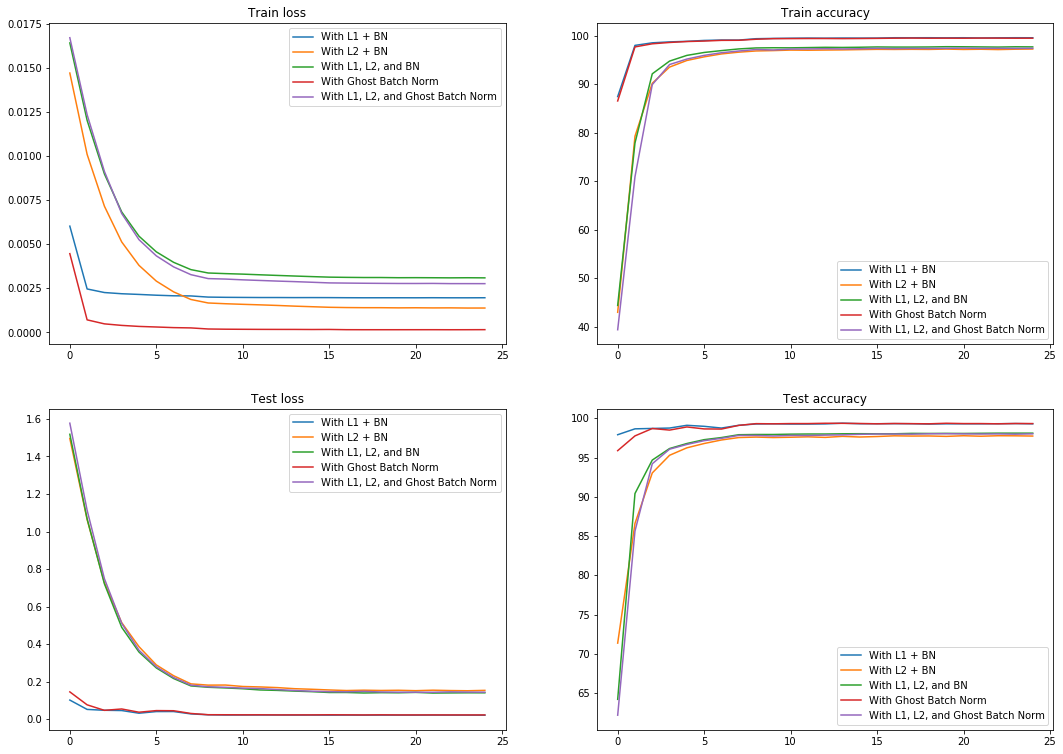

In [21]:
plot_curves_for_exps(*experiments)

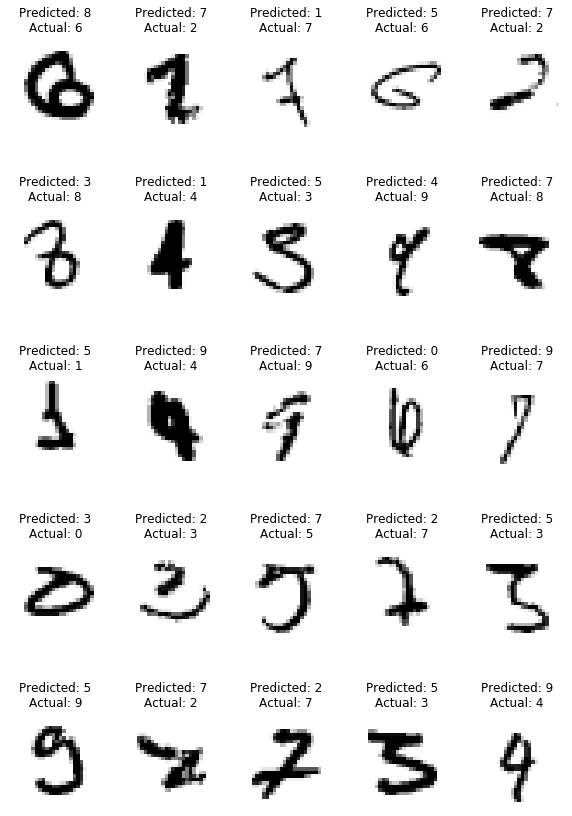

In [32]:
plot_misclassified(25, exp_4, test_loader, device)